# Helmholtz 1D Multilevel: Constant $k$ + Repetitive Coarsening
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.
* 

In [141]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
Kac   conv 0.90 shrinkage 0.70 PODR RER 0.39 after  8 sweeps. Work  1 efficiency 0.70
GS    conv 0.83 shrinkage 0.50 PODR RER 0.15 after  6 sweeps. Work  1 efficiency 0.50
kh 0.7
Kac   conv 0.92 shrinkage 0.71 PODR RER 0.39 after  8 sweeps. Work  1 efficiency 0.71
GS    conv 1.55 shrinkage 0.50 PODR RER 0.74 after  2 sweeps. Work  1 efficiency 0.50


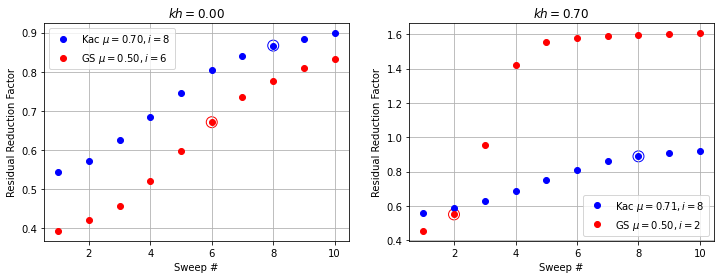

In [143]:
kh_values = [0, kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=None, max_sweeps=10, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [144]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [145]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     Relax conv 0.93 shrinkage 0.65 PODR RER 0.59 after 5 sweeps. Work 1.0 eff 0.65
INFO     Generating TVs with 5 sweeps
INFO     RER 0.634


In [146]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 5, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values, repetitive=repetitive)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.2717; mock cycle nu 2 conv 0.29 efficiency 0.74


In [147]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

,i,a,nc,cr,Energy Error,nu,conv,work,eff
0,0,2,1,0.50,0.47,1,0.64,2.00,0.80
1,0,2,1,0.50,0.47,2,0.35,4.00,0.77
2,0,2,1,0.50,0.47,3,0.24,6.00,0.79
3,0,2,1,0.50,0.47,4,0.26,8.00,0.85
4,1,4,1,0.25,0.61,1,0.86,1.33,0.89
5,1,4,1,0.25,0.61,2,0.86,2.67,0.94
6,1,4,1,0.25,0.61,3,0.89,4.00,0.97
7,1,4,1,0.25,0.61,4,0.83,5.33,0.96
8,2,4,2,0.50,0.27,1,0.63,2.00,0.80
9,2,4,2,0.50,0.27,2,0.29,4.00,0.74


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [148]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood, repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.967 asymptotic RQ -0.008 RER 0.146 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.1273; mock cycle nu 3 conv 0.18 eff 0.75
INFO     Mock cycle conv factor [0.648 0.337 0.195 0.132 0.146]
INFO     P max error: fit 0.066 val 0.037 test 0.077; alpha mean 0.005
INFO     all  set size 3  P L2 error mean 0.05 max 0.05 A error mean 0.13 max 0.14
INFO     Level 1 size 48
INFO     RER 0.262957
INFO     --------------------------------------------------------------------------------


<!-- ### Interpolation Error -->

In [149]:
# p = multilevel.level[1].p
# r = multilevel.level[1].r
# x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
# e = x - p.dot(r.dot(x))
# error = norm(e, axis=0) / norm(x, axis=0)
# error_a = norm(level.a.dot(e), axis=0) / norm(x, axis=0)
# print(error_a)
# # print(e[2])
# # print(p[2].todense())
# # print(x[2])

### Level 1 Relaxation Shrinkage Factor

INFO     Iter     |r|                 |x|         RER
INFO     0     3.299e-01            4.462e-01    0.740
INFO     1     1.530e-01 (0.463)    2.508e-01    0.612 (0.827)
INFO     2     7.153e-02 (0.477)    1.845e-01    0.389 (0.648)
INFO     3     3.848e-02 (0.537)    1.552e-01    0.249 (0.640)
INFO     4     2.561e-02 (0.663)    1.403e-01    0.182 (0.734)
INFO     5     1.872e-02 (0.730)    1.311e-01    0.142 (0.781)
INFO     6     1.540e-02 (0.822)    1.249e-01    0.123 (0.863)
INFO     7     1.342e-02 (0.871)    1.204e-01    0.111 (0.904)
INFO     8     1.207e-02 (0.899)    1.168e-01    0.103 (0.926)
INFO     9     1.105e-02 (0.916)    1.139e-01    0.097 (0.939)
INFO     10    1.024e-02 (0.927)    1.114e-01    0.092 (0.948)
kac   conv 0.93 shrinkage 0.60 PODR RER 0.12 after  6 sweeps. Work  1 efficiency 0.60


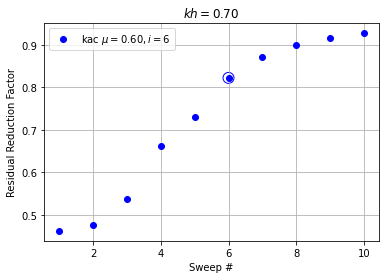

In [150]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=10, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

INFO     Iter     |r|                 |x|         RER
INFO     0     1.161e+00            4.471e-01    2.598
INFO     1     6.409e-01 (0.553)    3.530e-01    1.818 (0.700)
INFO     2     3.888e-01 (0.607)    3.086e-01    1.262 (0.694)
INFO     3     2.543e-01 (0.654)    2.839e-01    0.898 (0.711)
INFO     4     1.812e-01 (0.712)    2.679e-01    0.678 (0.755)
INFO     5     1.400e-01 (0.772)    2.562e-01    0.548 (0.808)
INFO     6     1.155e-01 (0.824)    2.468e-01    0.470 (0.856)
INFO     7     1.006e-01 (0.869)    2.388e-01    0.423 (0.899)
INFO     8     9.034e-02 (0.898)    2.318e-01    0.392 (0.925)
INFO     9     8.279e-02 (0.917)    2.256e-01    0.369 (0.942)
INFO     10    7.690e-02 (0.929)    2.199e-01    0.352 (0.954)
INFO     Relax conv 0.93 shrinkage 0.66 PODR RER 0.55 after 5 sweeps. Work 1.0 eff 0.66
INFO     Iter     |r|                 |x|         RER
INFO     0     1.318e+00            4.460e-01    2.962
INFO     1     2.137e+00 (1.630)    1.000e+00    2.137 (0.724)
I

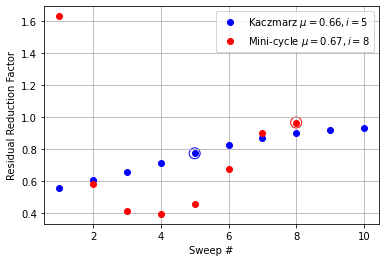

In [151]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [152]:
num_examples = 5
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel1.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.level.append(multilevel1.level[1])

INFO     Relax at level 0 size 48
INFO     Relax conv 0.92 shrinkage 0.55 PODR RER 0.17 after 4 sweeps. Work 1.0 eff 0.55
INFO     Generating TVs with 4 sweeps
INFO     RER 0.251
INFO     bootstrap on grid size 48 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.998 asymptotic RQ -0.030 RER 0.041 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (24, 48) a 6 nc 3 cr 0.50 mean_energy_error 0.0981; mock cycle nu 1 conv 0.27 eff 0.52
INFO     Mock cycle conv factor [0.297 0.15  0.078 0.066 0.029]
INFO     P max error: fit 0.035 val 0.021 test 0.096; alpha mean 0.002
INFO     all  set size 5  P L2 error mean 0.02 max 0.03 A error mean 0.02 max 0.03
INFO     Level 1 size 24
INFO     RER 0.079890
INFO     --------------------------------------------------------------------------------


Note that we are now able to reduce the RER of the TVs consisently with bootstrap cycles at level 1.

### Level 2 Relaxation Shrinkage

Level size 24
INFO     Iter     |r|                 |x|         RER
INFO     0     8.695e-02            4.463e-01    0.195
INFO     1     3.730e-02 (0.431)    2.348e-01    0.157 (0.817)
INFO     2     1.439e-02 (0.394)    1.460e-01    0.100 (0.635)
INFO     3     8.074e-03 (0.572)    1.186e-01    0.070 (0.706)
INFO     4     5.749e-03 (0.716)    1.042e-01    0.057 (0.818)
INFO     5     4.646e-03 (0.809)    9.484e-02    0.051 (0.894)
INFO     6     4.094e-03 (0.882)    8.754e-02    0.049 (0.960)
INFO     7     3.718e-03 (0.908)    8.129e-02    0.048 (0.982)
INFO     8     3.400e-03 (0.913)    7.575e-02    0.047 (0.984)
INFO     9     3.118e-03 (0.915)    7.080e-02    0.046 (0.983)
INFO     10    2.869e-03 (0.917)    6.633e-02    0.045 (0.983)
INFO     11    2.651e-03 (0.920)    6.227e-02    0.044 (0.983)
INFO     12    2.458e-03 (0.924)    5.856e-02    0.044 (0.985)
INFO     13    2.287e-03 (0.927)    5.514e-02    0.043 (0.986)
INFO     14    2.134e-03 (0.929)    5.199e-02    0.042 (0.

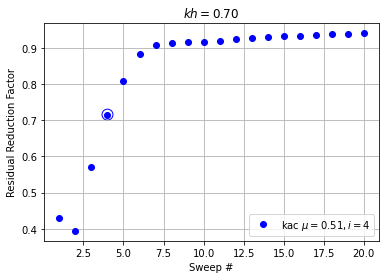

In [153]:
level = multilevel.level[2]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

INFO     Iter     |r|                 |x|         RER
INFO     0     1.184e+00            4.469e-01    2.649
INFO     1     6.732e-01 (0.571)    3.517e-01    1.922 (0.725)
INFO     2     4.052e-01 (0.604)    3.043e-01    1.338 (0.698)
INFO     3     2.631e-01 (0.651)    2.780e-01    0.951 (0.713)
INFO     4     1.866e-01 (0.709)    2.612e-01    0.717 (0.755)
INFO     5     1.440e-01 (0.771)    2.490e-01    0.580 (0.808)
INFO     6     1.190e-01 (0.825)    2.395e-01    0.498 (0.858)
INFO     7     1.028e-01 (0.864)    2.315e-01    0.445 (0.894)
INFO     8     9.164e-02 (0.891)    2.248e-01    0.408 (0.918)
INFO     9     8.323e-02 (0.908)    2.188e-01    0.381 (0.933)
INFO     10    7.663e-02 (0.920)    2.135e-01    0.359 (0.943)
INFO     11    7.130e-02 (0.930)    2.087e-01    0.342 (0.951)
INFO     Relax conv 0.93 shrinkage 0.68 PODR RER 0.50 after 6 sweeps. Work 1.0 eff 0.68
INFO     Iter     |r|                 |x|         RER
INFO     0     1.225e+00            4.467e-01    2.742
I

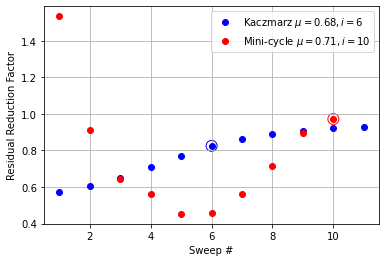

In [154]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.

### Operators

#### Level 0

In [155]:
pd.DataFrame(multilevel.level[0].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01


#### Level 1

In [156]:
pd.DataFrame(multilevel.level[1].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.15,-0.00,0.15,0.22,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.00,-0.74,-0.23,-0.33,-0.01,-0.03,0.00,0.00,0.00,0.00,0.00,0.00
2,0.15,-0.23,0.15,-0.00,0.15,0.22,0.01,0.01,0.00,0.00,0.00,0.00
3,0.22,-0.33,-0.00,-0.74,-0.23,-0.33,-0.01,-0.03,0.00,0.00,0.00,0.00
4,0.01,-0.01,0.15,-0.23,0.15,-0.00,0.15,0.22,0.01,0.01,0.00,0.00
5,0.01,-0.03,0.22,-0.33,-0.00,-0.74,-0.23,-0.33,-0.01,-0.03,0.00,0.00
6,0.00,0.00,0.01,-0.01,0.15,-0.23,0.15,-0.00,0.15,0.22,0.01,0.01
7,0.00,0.00,0.01,-0.03,0.22,-0.33,-0.00,-0.74,-0.23,-0.33,-0.01,-0.03
8,0.00,0.00,0.00,0.00,0.01,-0.01,0.15,-0.23,0.15,-0.00,0.15,0.22
9,0.00,0.00,0.00,0.00,0.01,-0.03,0.22,-0.33,-0.00,-0.74,-0.23,-0.33


In [157]:
pd.DataFrame(multilevel.level[1].p[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.36,-0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.60,-0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.61,0.38,0.07,0.12,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.37,0.49,-0.08,-0.17,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.08,0.21,-0.36,-0.46,0.00,0.00,0.00,0.00,0.00,0.00
5,0.06,-0.13,-0.60,-0.40,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,-0.61,0.38,0.07,0.12,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.37,0.49,-0.08,-0.17,0.00,0.00,0.00,0.00
8,0.00,0.00,-0.08,0.21,-0.36,-0.46,0.00,0.00,0.00,0.00
9,0.00,0.00,0.06,-0.13,-0.60,-0.40,0.00,0.00,0.00,0.00


#### Level 2

In [158]:
pd.DataFrame(multilevel.level[2].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.14,-0.03,-0.09,0.00,-0.10,-0.07,0.00,-0.01,-0.02,0.00,0.00,0.00
1,-0.03,-0.03,-0.02,0.05,0.06,0.04,0.00,0.00,0.01,0.00,0.00,0.00
2,-0.09,-0.02,0.14,-0.04,-0.04,-0.06,-0.00,-0.00,-0.00,0.00,0.00,0.00
3,0.00,0.05,-0.04,-0.14,-0.03,-0.09,0.00,-0.10,-0.07,0.00,-0.01,-0.02
4,-0.10,0.06,-0.04,-0.03,-0.03,-0.02,0.05,0.06,0.04,0.00,0.00,0.01
5,-0.07,0.04,-0.06,-0.09,-0.02,0.14,-0.04,-0.04,-0.06,-0.00,-0.00,-0.00
6,0.00,0.00,-0.00,0.00,0.05,-0.04,-0.14,-0.03,-0.09,0.00,-0.10,-0.07
7,-0.01,0.00,-0.00,-0.10,0.06,-0.04,-0.03,-0.03,-0.02,0.05,0.06,0.04
8,-0.02,0.01,-0.00,-0.07,0.04,-0.06,-0.09,-0.02,0.14,-0.04,-0.04,-0.06
9,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.05,-0.04,-0.14,-0.03,-0.09


In [159]:
pd.DataFrame(multilevel.level[2].p[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.12,0.43,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.37,0.13,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.14,-0.72,0.33,0.03,-0.13,-0.32,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.55,-0.14,0.27,-0.02,-0.07,-0.18,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.12,0.54,-0.45,-0.02,-0.11,-0.20,0.00,0.00,0.00,0.00,0.00,0.00
5,0.43,0.01,-0.04,-0.14,-0.08,-0.04,0.00,0.00,0.00,0.00,0.00,0.00
6,0.05,-0.07,0.08,-0.12,0.43,0.69,0.00,0.00,0.00,0.00,0.00,0.00
7,-0.21,0.02,0.04,0.37,0.13,0.08,0.00,0.00,0.00,0.00,0.00,0.00
8,0.05,-0.00,-0.01,0.14,-0.72,0.33,0.03,-0.13,-0.32,0.00,0.00,0.00
9,0.09,0.02,-0.02,-0.55,-0.14,0.27,-0.02,-0.07,-0.18,0.00,0.00,0.00


## How Does the Coarse Variables Look Like?
Print rows of $R_L \cdot \dots \cdot R_1$ and columns of $P_1 \cdot \dots \cdot P_L$ (for $L$ levels of coarsening).

In [160]:
r1 = multilevel.level[1].r
p1 = multilevel.level[1].p

r2 = multilevel.level[2].r
p2 = multilevel.level[2].p

p = p1.dot(p2)
r = r2.dot(r1)

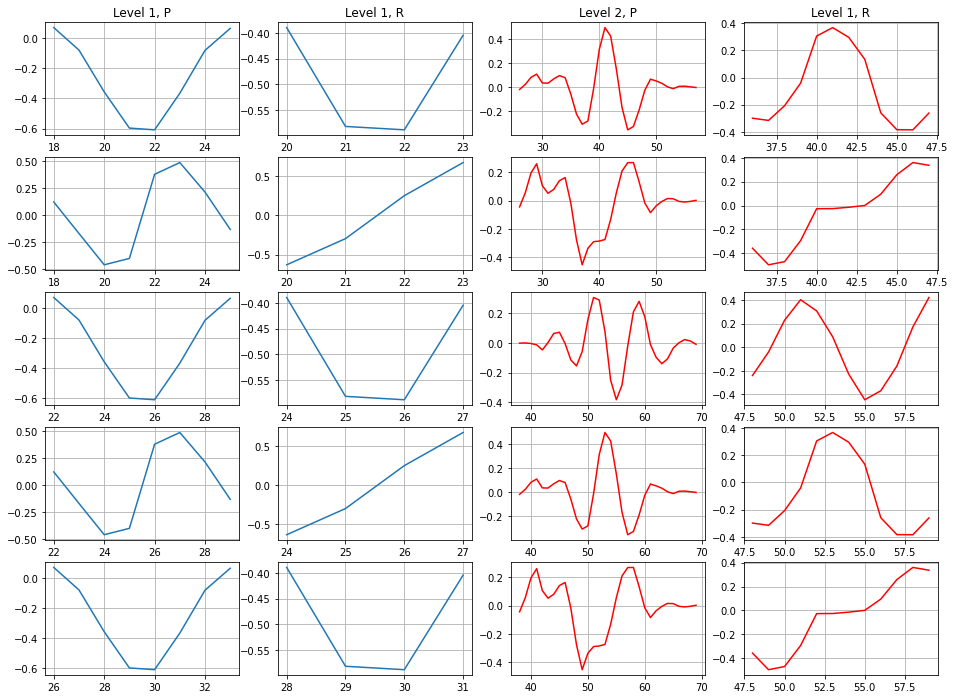

In [161]:
num_vars = 5
fig, axs = plt.subplots(num_vars, 4, figsize=(16, 12))
start_index = 10

col_titles = ("Level 1, P", "Level 1, R", "Level 2, P", "Level 1, R") 
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
    
for i in range(num_vars):
    j = start_index + i
    
    ax = axs[i, 0]
    ax.plot(p1[:, j].nonzero()[0], p1[:, j].data)
    ax.grid(True)
    
    ax = axs[i, 1]
    ax.plot(r1[j].nonzero()[1], r1[j].data)
    ax.grid(True)
    
    ax = axs[i, 2]
    ax.plot(p[:, j].nonzero()[0], p[:, j].data, "r")
    ax.grid(True)
    
    ax = axs[i, 3]
    ax.plot(r[j].nonzero()[1], r[j].data, "r")
    ax.grid(True)

The coarse variables ($R$) look like wavelets. The interpolations ($P$) look like a sync, all makes sense.

## Eigenpairs of the Different Level Operators

In [162]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.027 -0.027  0.062  0.062 -0.124 -0.124  0.143  0.143  0.216  0.216 -0.23  -0.23   0.28 ]
1 lam [-0.03  -0.03   0.062  0.062 -0.129 -0.131  0.145  0.145  0.218  0.218 -0.238 -0.238  0.28 ]
2 lam [-0.031 -0.031  0.059  0.059  0.091  0.1    0.1   -0.128 -0.142  0.164  0.164  0.18   0.185]


Looks like the smallest four eigenvalues are well approximated at all levels, to about $10\%$ error.

In [163]:
np.abs(laml[1][:10] - laml[0][:10]) / np.abs(laml[0][:10]), np.abs(laml[2][:10] - laml[0][:10]) / np.abs(laml[0][:10])

(array([0.126, 0.126, 0.012, 0.012, 0.037, 0.056, 0.009, 0.009, 0.009, 0.009]),
 array([0.153, 0.153, 0.062, 0.062, 1.732, 1.804, 0.303, 1.892, 1.656, 0.242]))

### What Level 1 eigenvectors comprise the level 2 AZM?
We calculate $(v^2_i)^T (R_2 v^1)$, which gives us the spectral decomposition coefficients of the level 2 eigenvector $v^2_i$ in terms of the coarsened level 1 eigenvectors.

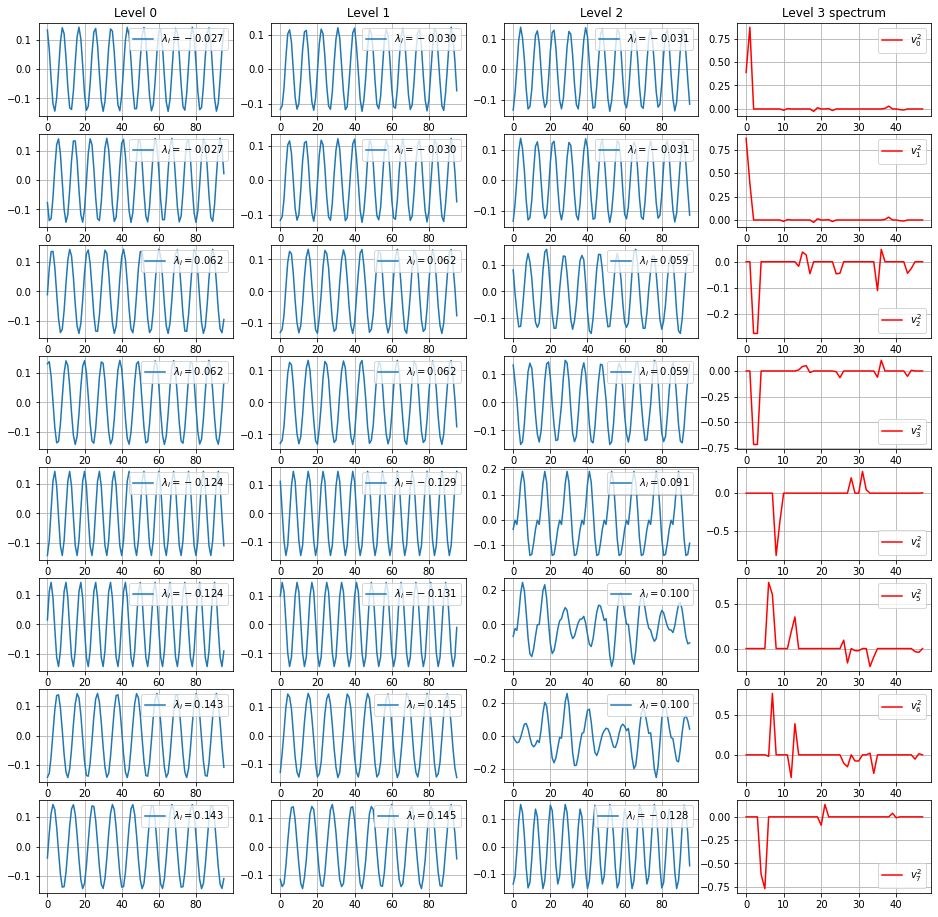

In [164]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

Each level $2$ eigenvecttor corresponds to one level $1$ eigenvector (we don't see the noise introduced by test vectors that vary across the domain here).

In [165]:
## Level 2 -> 3 Coarsening
num_examples = 8
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel2 = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel2 = hm.setup.auto_setup.bootstap(
        x, multilevel2, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel2.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.level.append(multilevel2.level[1])

INFO     Relax at level 0 size 24
INFO     Relax conv 0.89 shrinkage 0.45 PODR RER 0.07 after 3 sweeps. Work 1.0 eff 0.45
INFO     Generating TVs with 3 sweeps
INFO     RER 0.069
INFO     bootstrap on grid size 24 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.998 asymptotic RQ -0.029 RER 0.037 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (12, 24) a 6 nc 3 cr 0.50 mean_energy_error 0.3444; mock cycle nu 2 conv 0.25 eff 0.71
INFO     Mock cycle conv factor [0.485 0.243 0.169 0.138 0.111]
INFO     P max error: fit 0.151 val 0.310 test 0.419; alpha mean 0.200
INFO     all  set size 8  P L2 error mean 0.06 max 0.08 A error mean 0.01 max 0.02
INFO     Level 1 size 12
INFO     RER 0.046837
INFO     --------------------------------------------------------------------------------


### Level 3 Relaxation Shrinkage

Level size 12
INFO     Iter     |r|                 |x|         RER
INFO     0     4.271e-02            4.448e-01    0.096
INFO     1     1.921e-02 (0.454)    2.142e-01    0.088 (0.923)
INFO     2     7.654e-03 (0.421)    1.096e-01    0.071 (0.811)
INFO     3     3.983e-03 (0.527)    7.063e-02    0.057 (0.827)
INFO     4     2.555e-03 (0.627)    4.856e-02    0.053 (0.928)
INFO     5     1.759e-03 (0.677)    3.402e-02    0.052 (0.978)
INFO     6     1.238e-03 (0.696)    2.414e-02    0.051 (0.987)
INFO     7     8.831e-04 (0.708)    1.730e-02    0.050 (0.991)
INFO     8     6.355e-04 (0.716)    1.246e-02    0.050 (0.996)
INFO     9     4.589e-04 (0.720)    8.989e-03    0.050 (0.999)
INFO     10    3.315e-04 (0.722)    6.489e-03    0.050 (1.001)
INFO     11    2.393e-04 (0.721)    4.685e-03    0.050 (1.000)
INFO     12    1.726e-04 (0.721)    3.382e-03    0.050 (1.000)
INFO     13    1.245e-04 (0.720)    2.442e-03    0.050 (0.999)
INFO     14    8.977e-05 (0.720)    1.764e-03    0.050 (0.

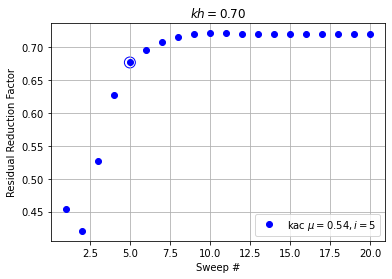

In [166]:
level = multilevel.level[3]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

On this level, relaxation converges quickly, so we can stop coarsening.

# Test Multilevel Cycle Convergence

### Solving $A x = 0$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. Starting from random. Even solving exactly on the coarsest level works here.

In [167]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1).run(x)
_, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO         0 |r| 7.586e+00 RER 1.58122
INFO         1 |r| 2.344e+00 (0.30898) RER 1.23851 (0.78326) 1.892
INFO         2 |r| 7.557e-01 (0.32241) RER 1.52484 (1.23119) 0.496
INFO         3 |r| 2.378e-01 (0.31473) RER 1.61576 (1.05963) 0.147
INFO         4 |r| 8.507e-02 (0.35768) RER 1.76193 (1.09047) 0.048
INFO         5 |r| 3.163e-02 (0.37187) RER 1.38585 (0.78655) 0.023
INFO         6 |r| 1.133e-02 (0.35814) RER 1.82344 (1.31575) 0.006
INFO         7 |r| 4.040e-03 (0.35657) RER 2.00825 (1.10135) 0.002
INFO         8 |r| 1.444e-03 (0.35735) RER 1.82906 (0.91077) 0.001
INFO         9 |r| 5.008e-04 (0.34688) RER 1.82071 (0.99544) 0.000
INFO        10 |r| 1.794e-04 (0.35824) RER 2.01683 (1.10771) 0.000
INFO        11 |r| 6.684e-05 (0.37258) RER 1.74910 (0.86725) 0.000
INFO        12 |r| 2.620e-05 (0.39203) RER 1.68575 (0.96378) 0.000
INFO        13 |r| 1.006e-05 (0.38395) RER 2.06376 (1.22424) 0.000
INFO        14 |r| 3.601e-06 (0.35790) RER 2.09106 (1.01323) 0.000
INFO        15 |r| 1.

In [168]:
for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

V(1, 1) conv factor 0.362
V(2, 1) conv factor 0.183
V(3, 1) conv factor 0.135
V(4, 1) conv factor 0.124


### Solving $Ax = b$
Works the same way as for $Ax = 0$.

In [169]:
# Random RHS.
b = np.random.random((a0.shape[0], ))

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO         0 |r| 8.304e+00 RER 1.35838
INFO         1 |r| 3.007e+00 (0.36216) RER 0.17975 (0.13233) 16.731
INFO         2 |r| 9.894e-01 (0.32898) RER 0.06140 (0.34158) 16.114
INFO         3 |r| 3.301e-01 (0.33365) RER 0.02045 (0.33311) 16.139
INFO         4 |r| 1.029e-01 (0.31159) RER 0.00635 (0.31036) 16.204
INFO         5 |r| 3.721e-02 (0.36174) RER 0.00230 (0.36203) 16.191
INFO         6 |r| 1.414e-02 (0.37991) RER 0.00087 (0.37991) 16.191
INFO         7 |r| 5.106e-03 (0.36122) RER 0.00032 (0.36128) 16.188
INFO         8 |r| 1.599e-03 (0.31307) RER 0.00010 (0.31305) 16.189
INFO         9 |r| 5.354e-04 (0.33496) RER 0.00003 (0.33497) 16.189
INFO        10 |r| 1.875e-04 (0.35011) RER 0.00001 (0.35011) 16.189
INFO        11 |r| 6.644e-05 (0.35442) RER 0.00000 (0.35442) 16.189
INFO        12 |r| 2.451e-05 (0.36893) RER 0.00000 (0.36893) 16.189
INFO        13 |r| 9.575e-06 (0.39061) RER 0.00000 (0.39061) 16.189
INFO        14 |r| 3.403e-06 (0.35538) RER 0.00000 (0.35538) 16.189
INFO   

### Solving $A x = \lambda x$
Work in progress.

In [170]:
# level = multilevel.finest_level
# lam = 0

# eigen_cycle = lambda x, lam: hm.setup_eigen.eigensolver.eigen_cycle(multilevel, 1.0, 1, 1, 100, debug=True).run((x, lam))
# # FMG start so (x, lambda) has a reasonable initial guess.
# #x = hm.setup_eigen.bootstrap_eigen.fmg(multilevel, num_cycles_finest=0)
# x = np.random.random((a0.shape[0], 1))
# x, lam, conv_factor = hm.solve.run.run_iterative_eigen_method(level.operator, eigen_cycle, x, lam, 20, print_frequency=1)

## Automating the Entire Setup Phase
Looks like the process is sensitive in two ways depending on the random seed (used to generate the initial TV at each level):
* We might not find a good coarsening whose mock cycle rate < $0.4$ (the maximum allowed).
* We might have too many interpolation points and not enough windows/test vectors. Especially if we coarsen by 6/4 at some point (that's because we do not yet truncate small $P$ weight).
* The ML cycle may strongly diverge because of a particular level.
* The domain size may not be divisible by the the aggregate size. $R$ can be periodic with an overlapping aggregate, but $P$ cannot be.

### A Happy Case

In [205]:
np.random.seed(1)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     level 0 size 96 relax conv 0.96 shrinkage 0.72 PODR RER 0.40 after 8 sweeps. Work 1.0 eff 0.72
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.389
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.964 asymptotic RQ -0.064 RER 0.136 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.1088; mock cycle nu 3 conv 0.18 eff 0.75
INFO     Mock cycle conv factor [0.306 0.187 0.131]
INFO     P max error: fit 0.042 val 0.033 test 0.033; alpha mean 0.003
INFO     all  set size 2  P L2 error mean 0.03 max 0.03 A error mean 0.06 max 0.07
INFO     Level 1 size 48
INFO     RER 0.168867
INFO     --------------------------

### Case of Slow Solution Cycle

In [203]:
np.random.seed(2)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     level 0 size 96 relax conv 0.96 shrinkage 0.73 PODR RER 0.41 after 8 sweeps. Work 1.0 eff 0.73
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.402
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.942 asymptotic RQ -0.052 RER 0.150 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0891; mock cycle nu 3 conv 0.19 eff 0.76
INFO     Mock cycle conv factor [0.322 0.188 0.127]
INFO     P max error: fit 0.040 val 0.043 test 0.131; alpha mean 0.005
INFO     all  set size 2  P L2 error mean 0.03 max 0.03 A error mean 0.07 max 0.08
INFO     Level 1 size 48
INFO     RER 0.201686
INFO     --------------------------

### Dependence on $kh$
$kh = 0.5$ is supposedly the hardest case. Here it works with the same efficiency as $kh = 0.7$.

In [214]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

np.random.seed(0)
multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                      max_levels=3)
print ("#levels", len(multilevel.level))

for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

INFO     level 0 size 96 relax conv 0.96 shrinkage 0.71 PODR RER 0.39 after 8 sweeps. Work 1.0 eff 0.71
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.361
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.992 asymptotic RQ 0.188 RER 0.229 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 2 nc 1 cr 0.50 mean_energy_error 0.2529; mock cycle nu 2 conv 0.26 eff 0.71
INFO     Mock cycle conv factor [0.276 0.223 0.23 ]
INFO     P max error: fit 0.031 val 0.028 test 0.099; alpha mean 0.000
INFO     all  set size 2  P L2 error mean 0.03 max 0.03 A error mean 0.12 max 0.12
INFO     Level 1 size 48
INFO     RER 0.157888
INFO     ---------------------------

### Dependence on Problem Size
Convergence degrades with increasing size at the moment. Sometimes the cycle completely diverges.

In [231]:
kh = 0.5
for n in 96 * 2 ** np.arange(4):
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

    np.random.seed(2)
    multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                          max_levels=3)
    print("n", n, "#levels", len(multilevel.level))

    for nu in range(1, 5):
        two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
        _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((multilevel.level[0].size, )), 20)
        print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

INFO     level 0 size 96 relax conv 0.96 shrinkage 0.72 PODR RER 0.37 after 8 sweeps. Work 1.0 eff 0.72
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.384
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.996 asymptotic RQ 0.226 RER 0.242 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 2 nc 1 cr 0.50 mean_energy_error 0.1405; mock cycle nu 2 conv 0.27 eff 0.72
INFO     Mock cycle conv factor [0.273 0.222 0.235]
INFO     P max error: fit 0.038 val 0.035 test 0.052; alpha mean 0.000
INFO     all  set size 2  P L2 error mean 0.03 max 0.04 A error mean 0.14 max 0.16
INFO     Level 1 size 48
INFO     RER 0.181811
INFO     ---------------------------